# DCGAN

*Deep Convolitional GAN*

畳み込み層を用いたGAN。DCGANではなく普通にGANと呼ばれることも多い。

In [24]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm


batch_size = 64
nz = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MNIST

In [2]:
dataset = MNIST(
    root="datasets/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_x, _ = next(iter(dataloader))
print("batch shape: ", sample_x.shape)

batch shape:  torch.Size([64, 1, 28, 28])


## Discriminator



In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._conv(1, 16, 4, 2, 1),
            self._conv(16, 32, 4, 2, 1),
            self._conv(32, 64, 3, 2, 0),
            nn.Conv2d(64, 128, 3, 1, 0),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def _conv(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        y = self.net(x)
        return y

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 128, 3, 1, 0),
            self._convT(128, 64, 3, 2, 0),
            self._convT(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

## 学習

In [5]:
def make_noise(batch_size):
    return torch.randn(batch_size, nz, 1, 1, device=device)

def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

In [11]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1, progress=True, print_interval=1):
    netD.train()
    netG.train()
    for epoch in range(n_epochs):
        epoch += 1
        lossD_list = []
        lossG_list = []
        for X, _ in tqdm(dataloader, disable=not progress):
            X = X.to(device)
            optimD.zero_grad()
            optimG.zero_grad()

            z = make_noise(batch_size)
            fake = netG(z)
            pred_fake = netD(fake)
            pred_real = netD(X)
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real = criterion(pred_real, real_labels)
            lossD = loss_fake + loss_real
            lossD.backward()
            optimD.step()

            fake = netG(z)
            pred = netD(fake)
            lossG = criterion(pred, real_labels)
            lossG.backward()
            optimG.step()

            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        if print_interval and epoch % print_interval == 0:
            print(f'{epoch:>3}epoch | lossD: {lossD}, lossG: {lossG}')
        if write_interval and epoch % write_interval == 0:
            write(netG)

  1epoch | lossD: 0.10694633424282074, lossG: 6.514482021331787
  2epoch | lossD: 0.0878065899014473, lossG: 6.164546012878418
  3epoch | lossD: 0.13456089794635773, lossG: 5.780481338500977
  4epoch | lossD: 0.5991073250770569, lossG: 5.152936935424805
  5epoch | lossD: 0.3598220944404602, lossG: 3.1640868186950684


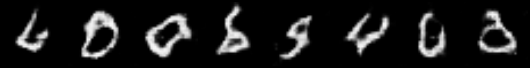

  6epoch | lossD: 0.5292609930038452, lossG: 3.885258674621582
  7epoch | lossD: 0.4436909258365631, lossG: 2.293076753616333
  8epoch | lossD: 0.5975441932678223, lossG: 2.138929843902588
  9epoch | lossD: 0.48572587966918945, lossG: 2.7086663246154785
 10epoch | lossD: 1.953120470046997, lossG: 0.6706354022026062


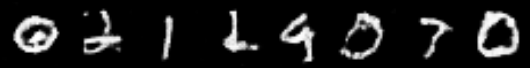

 11epoch | lossD: 0.5793634653091431, lossG: 2.050942897796631
 12epoch | lossD: 0.8794665336608887, lossG: 1.1007912158966064
 13epoch | lossD: 1.1008901596069336, lossG: 1.0996456146240234
 14epoch | lossD: 1.1108167171478271, lossG: 2.521780490875244
 15epoch | lossD: 0.9850063323974609, lossG: 1.1251332759857178


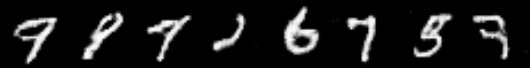

 16epoch | lossD: 0.6702980399131775, lossG: 2.5872621536254883
 17epoch | lossD: 0.8585845232009888, lossG: 1.349671721458435
 18epoch | lossD: 1.1869556903839111, lossG: 1.5150911808013916
 19epoch | lossD: 0.9451034069061279, lossG: 1.3784164190292358
 20epoch | lossD: 1.1098796129226685, lossG: 0.9495764970779419


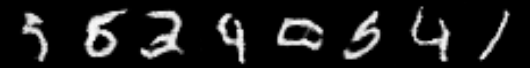

 21epoch | lossD: 0.4919157028198242, lossG: 2.1384592056274414
 22epoch | lossD: 1.2810003757476807, lossG: 2.2876436710357666
 23epoch | lossD: 0.5865094065666199, lossG: 2.113922595977783
 24epoch | lossD: 1.096717357635498, lossG: 1.9448013305664062
 25epoch | lossD: 0.6610574722290039, lossG: 2.0984396934509277


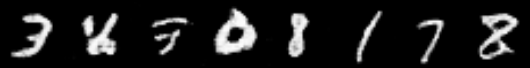

 26epoch | lossD: 0.781843364238739, lossG: 1.6455309391021729
 27epoch | lossD: 0.9673261642456055, lossG: 1.2605993747711182
 28epoch | lossD: 1.8981926441192627, lossG: 0.7817733883857727
 29epoch | lossD: 1.3093202114105225, lossG: 1.0990065336227417
 30epoch | lossD: 0.8726884722709656, lossG: 1.2802166938781738


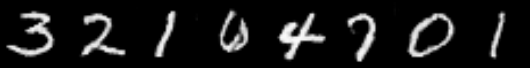

In [7]:
netD = Discriminator().to(device)
netG = Generator(nz).to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 30

train(netD, netG, optimD, optimG, n_epochs, 5, False)

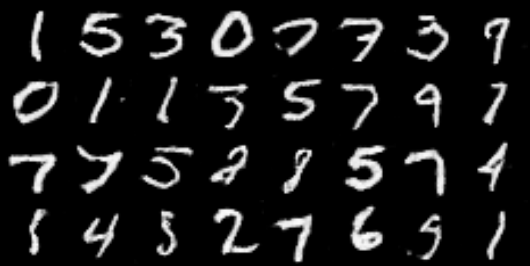

In [9]:
write(netG, 4)


---

## ポケモンを作ってみる

### データセット

[Pokemon Images Dataset | Kaggle](https://www.kaggle.com/kvpratama/pokemon-images-dataset)

In [10]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(
    "datasets/pokemon",
    transform=transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(),
    ])
)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:]
image_size = w * h # 画像のサイズ
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 3, 64, 64])
width: 64
height: 64
image size: 4096


### Discriminator

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._conv(3, 32, 4, 2, 1), # 32
            self._conv(32, 64, 4, 2, 1), # 16
            self._conv(64, 128, 4, 2, 1), # 8
            self._conv(128, 256, 4, 2, 1), # 4
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def _conv(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        y = self.net(x)
        return y

### Generator

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 256, 4, 1, 0), # 4
            self._convT(256, 128, 4, 2, 1), # 8
            self._convT(128, 64, 4, 2, 1), # 16
            self._convT(64, 32, 4, 2, 1), # 32
            nn.ConvTranspose2d(32, 3, 4, 2, 1), # 64
            nn.Tanh()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

### 学習

In [33]:
# ノイズを生成する関数
def make_noise(batch_size=batch_size):
    return torch.randn(batch_size, nz, 1, 1, device=device)

# 画像を生成して描画する関数
def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = (images + 1) / 2
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

In [40]:
real_labels = torch.zeros(batch_size, 1).to(device)
fake_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()


def train(netD, netG, optimD, optimG, n_epochs, draw_freq=10):
    for epoch in range(1, n_epochs+1):
        for x, _ in dataloader:
            x = x * 2 - 1
            x = x.to(device)

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # 識別器の学習 -----------------------------------------------
            z = make_noise()
            fake = netG(z)
            pred_fake = netD(fake)
            pred_real = netD(x)
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real = criterion(pred_real, real_labels)
            lossD = loss_fake + loss_real
            lossD.backward()
            optimD.step()

            # 生成器の学習 -----------------------------------------------
            fake = netG(z)
            pred = netD(fake)
            lossG = criterion(pred, real_labels)
            lossG.backward()
            optimG.step()

        if epoch % draw_freq == 0:
            print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
            write(netG)

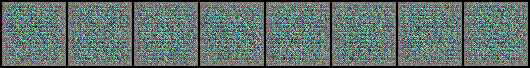

In [43]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)

write(netG)

  5epoch | lossD: 0.9553, lossG: 0.0148


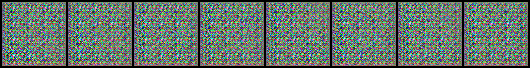

 10epoch | lossD: 0.7374, lossG: 0.0181


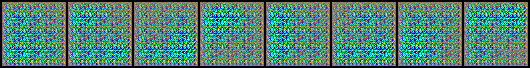

In [44]:
train(netD, netG, optimD, optimG, 50, draw_freq=5)